In [ ]:
# Bibliotecas

# Biblioteca de Conexão com Bando de Dados
import mysql.connector

# Biblioteca de Mondelagem e Criações de Dados 
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

**Realizado Conexão com MYSQL e extraido os dados para Manipulação dos dados**

In [16]:
# Parâmetros de conexão
server = 'localhost'
database = 'estudos'
username = 'root'
senha = '1234'

# Criar conexão com MySQL
conn = mysql.connector.connect(
    host=server,
    database=database,
    user=username,
    password=senha
)

# Executar query
dados = pd.read_sql_query('SELECT * FROM tb_acompanhamento_cobranca;', con=conn)

dados.to_csv(r'C:\Users\ezequ\Scripts\01 - Python\02 - MEUS_PROJETOS\04 - CONEXÃO_COM_ODBC\Datasets\Dados_mysql.csv', sep="|")

# Fechar conexão
conn.close()

C:\Users\ezequ\AppData\Local\Temp\ipykernel_3976\1428622790.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dados = pd.read_sql_query('SELECT * FROM tb_acompanhamento_cobranca;', con=conn)


**Manipulando os dados com Pandas e criado tabelas sinteticas**

In [ ]:
# Criando uma nova coluna 'VALOR_PRODUTIVO' com base na condição 'PRODUTIVO' == 1
dados['VALOR_PRODUTIVO'] = dados.apply(lambda row: dados.loc[row.name, 'VALOR_TOTAL'] if row['PRODUTIVO'] == 1 else 0, axis=1)

# Criando uma nova coluna 'VALOR_PROMESSA' com base na condição 'PROMESSA' == 1
dados['VALOR_PROMESSA'] = dados.apply(lambda row: dados.loc[row.name, 'VALOR_TOTAL'] if row['PROMESSA'] == 1 else 0, axis=1)

# Criando uma nova coluna 'VALOR_IMPRODUTIVO' com base na condição 'IMPRODUTIVO' == 1
dados['VALOR_IMPRODUTIVO'] = dados.apply(lambda row: dados.loc[row.name, 'VALOR_TOTAL'] if row['IMPRODUTIVO'] == 1 else 0, axis=1)


# Realizado o Agrupamento da Minha Base para criação da minha Base
Base_01 = dados.groupby(['CONTRATANTE','OPERADOR']).agg(
    #Soma Trabalhado
    TRABALHADO = ('TRABALHADO','sum'),
    #Soma Produtivo
    PRODUTIVO = ('PRODUTIVO','sum'),
    #Soma Promessa
    PROMESSA = ('PROMESSA','sum'),
    #Soma Valor_Produtivo
    VALOR_PRODUTIVO = ('VALOR_PRODUTIVO', 'sum'),
    # Soma Valor_Promessa
    VALOR_PROMESSA = ('VALOR_PROMESSA', 'sum'),
    #Soma Improdutivo
    IMPRODUTIVO = ('IMPRODUTIVO','sum'),
    # Soma Valor_Promessa
    VALOR_IMPRODUTIVO = ('VALOR_IMPRODUTIVO', 'sum')
).reset_index()

# Calculando o Porcentual Produtivo
Base_01['PERCT_PRODUTIVO'] = round(Base_01['PRODUTIVO'] / Base_01['TRABALHADO']*100,2)
Base_01['PERCT_PROMESSA'] = round(Base_01['PROMESSA'] / Base_01['TRABALHADO']*100,2)

# Alterando o Formato das Colunas Valores, para REAL
Base_01['VALOR_PRODUTIVO'] = Base_01['VALOR_PRODUTIVO'].apply(lambda valor: f'R$ {valor:,.2f}')
Base_01['VALOR_PROMESSA'] = Base_01['VALOR_PROMESSA'].apply(lambda valor: f'R$ {valor:,.2f}')
Base_01['VALOR_IMPRODUTIVO'] = Base_01['VALOR_IMPRODUTIVO'].apply(lambda valor: f'R$ {valor:,.2f}')

# Alterando o Formato das Colunas PORCENTUAIS
Base_01['PERCT_PRODUTIVO'] = Base_01['PERCT_PRODUTIVO'].apply(lambda valor: f'{valor:,.2f}%')
Base_01['PERCT_PROMESSA'] = Base_01['PERCT_PROMESSA'].apply(lambda valor: f'{valor:,.2f}%')

# Alterando os Nomes das Colunas para Adpatação em Foto
Base_01 = Base_01.rename(columns={'VALOR_PRODUTIVO': 'R$_PRODUTIVO'})
Base_01 = Base_01.rename(columns={'VALOR_PROMESSA': 'R$_PROMESSA'})
Base_01 = Base_01.rename(columns={'VALOR_IMPRODUTIVO': 'R$_IMPRODUTIVO'})
Base_01 = Base_01.rename(columns={'PERCT_PRODUTIVO': '%PRODUTIVO'})
Base_01 = Base_01.rename(columns={'PERCT_PROMESSA': '%PROMESSA'})

# Realiza a troca do cravamento (Envio de 2° Via) para (Contato sem Agendamento)
dados['DESCRICAO'] = dados['DESCRICAO'].replace('ENVIO DE 2° VIA', 'CONTATO SEM AGENDAMENTO')

# Criando Base de Dados das Tabulações Produtivas
dados_p = dados.loc[dados['PRODUTIVO'] == 1]

# Criando Base de Dados das Tabulações Improdutivas
dados_i = dados.loc[dados['IMPRODUTIVO'] == 1]

# Realizado a Agrupamento para criação da 2 Base
Base_02 = dados_p.groupby(['CONTRATANTE','DESCRICAO']).agg(
    QTDE = ('TRABALHADO','count'),
    VALOR = ('VALOR_TOTAL', 'sum')
).reset_index()

# Mudado para 3 casas decimais
Base_02['VALOR'] = Base_02['VALOR'].apply(lambda valor: f'R$ {valor:,.2f}')

# Realizado a Agrupamento para criação da 3 Base
Base_03 = dados_i.groupby(['CONTRATANTE','DESCRICAO']).agg(
    QTDE = ('TRABALHADO','count'),
    VALOR = ('VALOR_TOTAL', 'sum')
).reset_index()

# Mudado para 3 casas decimais
Base_03['VALOR'] = Base_03['VALOR'].apply(lambda valor: f'R$ {valor:,.2f}')

**Criando Fotos para report informações extraidas do Banco**

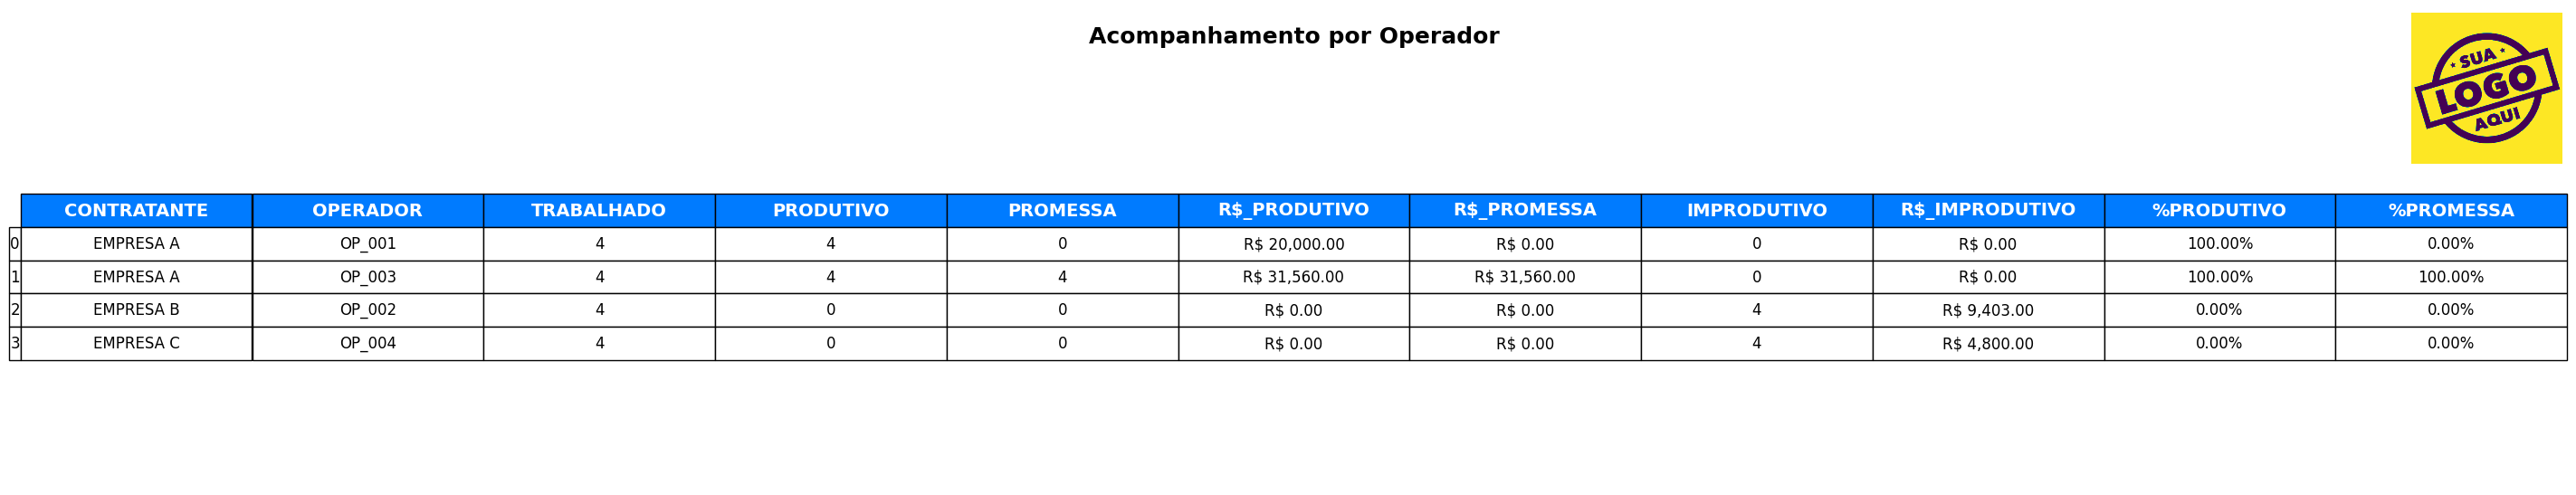

In [45]:
def gerar_imagem_tabela(df, titulo, caminho_imagem, caminho_logo=None):
    """
    Gera uma imagem de uma tabela a partir de um DataFrame e salva em um arquivo.

    Parâmetros:
    - df (pd.DataFrame): DataFrame com os dados da tabela.
    - titulo (str): Título da tabela.
    - caminho_imagem (str): Caminho para salvar a imagem gerada.
    - caminho_logo (str, opcional): Caminho da imagem do logotipo (se houver).
    """

    # Criando a figura e o eixo
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')  # Remove os eixos

    # Removendo o índice da tabela
    df = df.reset_index(drop=True)

    # Adicionando título
    ax.set_title(titulo, fontsize=18, fontweight='bold', loc='center', pad=20)

    # Criando a tabela
    col_widths = [0.15] * len(df.columns)
    tab = table(ax, df, loc='center', cellLoc='center', colWidths=col_widths)

    # Ajustes visuais
    tab.auto_set_font_size(False)
    tab.set_fontsize(12)
    tab.scale(2.2, 2.2)

    # Personalizando cabeçalho
    for i in range(len(df.columns)):
        cell = tab.get_celld()[0, i]
        cell.set_facecolor("#007BFF")  # Azul profissional
        cell.set_edgecolor("black")  # Bordas pretas
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold', color='white')

    # Adicionando logotipo (se informado)
    if caminho_logo:
        try:
            logo = plt.imread(caminho_logo)
            imgbox = OffsetImage(logo, zoom=0.2)  # Ajuste o zoom para reduzir o tamanho da logo
            ab = AnnotationBbox(imgbox, (2.2, 0.95),  # Posição no canto superior esquerdo
                                frameon=False, xycoords='axes fraction')
            ax.add_artist(ab)
        except FileNotFoundError:
            print(f"Erro: Arquivo de logotipo não encontrado em {caminho_logo}")

    # Salvando a imagem
    plt.savefig(caminho_imagem, bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

# Chamado a função
gerar_imagem_tabela(Base_01, "Acompanhamento por Operador", r'C:\Users\ezequ\Scripts\01 - Python\02 - MEUS_PROJETOS\04 - CONEXÃO_COM_ODBC\Reports\tabela_imagem_1.png', r'C:\Users\ezequ\Scripts\01 - Python\02 - MEUS_PROJETOS\04 - CONEXÃO_COM_ODBC\assets\logo.png')

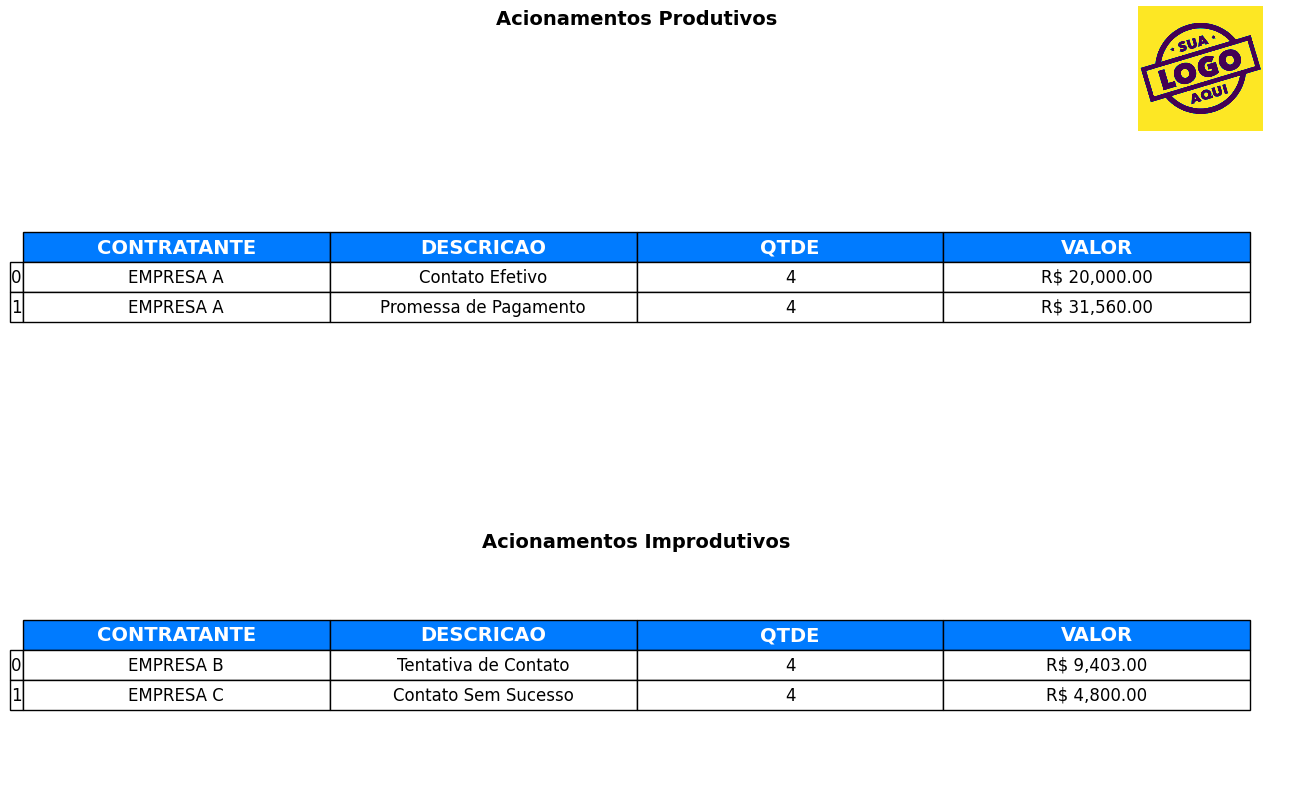

In [51]:
def gerar_imagem_tabelas(df_list, titulos, caminho_imagem, caminho_logo=None):
    """
    Gera uma imagem contendo duas tabelas a partir de DataFrames.

    Parâmetros:
    - df_list (list): Lista de DataFrames para exibir.
    - titulos (list): Lista de títulos das tabelas.
    - caminho_imagem (str): Caminho para salvar a imagem gerada.
    - caminho_logo (str, opcional): Caminho da imagem do logotipo (se houver).
    """

    # Criando a figura com dois subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Espaçamento dos títulos
    pads = [100, 0]  

    # Loop para criar as tabelas
    for i, ax in enumerate(axes):
        ax.axis('off')  # Remove os eixos
        ax.set_title(titulos[i], fontsize=14, fontweight='bold', pad=pads[i])

        # Removendo o índice da tabela
        df = df_list[i].reset_index(drop=True)

        # Definição de larguras das colunas (ajustável)
        col_widths = [0.15] * len(df.columns)

        # Criando a tabela
        tab = table(ax, df, loc='center', cellLoc='center', colWidths=col_widths)

        # Ajustes visuais
        tab.auto_set_font_size(False)
        tab.set_fontsize(12)
        tab.scale(2.2, 2.2)

        # Personalizando cabeçalho
        for j in range(len(df.columns)):
            cell = tab.get_celld()[0, j]
            cell.set_facecolor("#007BFF")  # Azul profissional
            cell.set_edgecolor("black")  # Bordas pretas
            cell.set_fontsize(14)
            cell.set_text_props(weight='bold', color='white')

    # Ajustando o espaço entre as tabelas
    plt.subplots_adjust(hspace=0.7)

    # Adicionando logotipo no canto superior esquerdo (se informado)
    if caminho_logo:
        try:
            logo = plt.imread(caminho_logo)
            imgbox = OffsetImage(logo, zoom=0.15)  # Reduz tamanho da logo
            ab = AnnotationBbox(imgbox, (1, 0.90), frameon=False, xycoords='figure fraction')
            fig.add_artist(ab)
        except FileNotFoundError:
            print(f"Erro: Logo não encontrada em {caminho_logo}")

    # Salvando a imagem
    plt.savefig(caminho_imagem, bbox_inches='tight', pad_inches=0.5, dpi=300)
    plt.show()

# Chamado a Função:
gerar_imagem_tabelas([Base_02, Base_03], ["Acionamentos Produtivos", "Acionamentos Improdutivos"],
                      r'C:\Users\ezequ\Scripts\01 - Python\02 - MEUS_PROJETOS\04 - CONEXÃO_COM_ODBC\Reports\tabela_imagem_2.png', r'C:\Users\ezequ\Scripts\01 - Python\02 - MEUS_PROJETOS\04 - CONEXÃO_COM_ODBC\assets\logo.png')